**Harmonic oscillator program**

extracting first excited state of harmonic oscillator

In [40]:
import numpy as np
from numpy.random import uniform 
import matplotlib.pyplot as plt
from math import *

defining the parameters

In [56]:
N=20
N_cor = 20
N_cf = 10000
N_stat=100
a = .5
epsilon = 1.4
m=1
x = np.zeros((N,),np.float64)
G = np.zeros((N_cf,N),np.float64)
G_avgs=np.zeros((N,N_stat),np.float64)
G_sim=np.zeros((N_stat,N_cf,N),np.float64)

**action**

with only the terms concerning a certain x_j (harmonic oscillator)
enters the metropolis update



In [42]:
def S(j,x,m,a):
    jp = (j+1)%len(x)    # next site
    jm = (j-1)%len(x)    # previous site
    return a*((x[j])**2)/2 + x[j]*(x[j]-x[jp]-x[jm])*(m/a)

**Metropolis sweep**

for x (x is an array of length N)
meanwhile it calculates the acceptance rate for this x

we want: acceptance rate between 40-60%

In [43]:
#Metropolis sweep 
def update(x,m,a,epsilon):
    accept=0
    
    for i in range(len(x)):
        x_old=x[i]
        S_old=S(i,x,m,a)
        
        noise=uniform(-epsilon,epsilon)
        x[i]+=noise
        S_new=S(i,x,m,a)
        dS= S_new-S_old
        
        if dS > 0 and exp(-dS)<uniform(0,1):
            x[i]=x_old
        else:
            accept += 1
            
    return accept/len(x)

**compute G_n**

In [44]:
def computeG(x,n): #compute G_n
    g=0
    N=len(x)
    for i in range(N):
        g+=x[i]*x[(i+n)%N]
    return g/N

**Monte Carlo average**

In [52]:
def MCaverage(x,G,N_corr,N_cf):
    N=len(x)
    accepted=0
    for j in range(10*N_corr):
        #accepted+=
        update(x,m,a,epsilon)
    accepted=accepted/(10*N_corr)
    for alpha in range(N_cf):
        for i in range(N_corr):
            accepted+=update(x,m,a,epsilon)
        for n in range(N):
            G[alpha][n] = computeG(x,n)
    accepted=accepted/(N_cf*N_corr)
    #in the end we have a matrix with N_cf rows and len(x) columns
    #we have to compute averages summing over alphas
    G_sim[0]=G
    for k in range(1,N_stat):
        G_sim[k]=bootstrap(G)
    #G_avgs=[]
    for k in range(N_stat):
        for n in range(N):
            avg=0
            for alpha in range(N_cf):
                G_avgs[n][k]+=G_sim[k][alpha][n]
            G_avgs[n][k]=G_avgs[n][k]/N_cf
    #print(f"averages: {G_avgs}")
    return G_avgs,accepted

**DeltaE calculation**

In [47]:
#returns an array of averages of length N [Gavg0, ..., Gavg(N-1)]
def DeltaE(G_avgs):
    for k in range(N_stat):
        for n in range(N-1):
            dE[n][k] =np.log(np.abs(G_avgs[n][k]/G_avgs[n+1][k]))/a
            #np.log(np.divide(G_avgs[:-1],G_avgs[1:]))
            t[n]=n*a
            #exact[n]=1
    return dE

In [48]:
def stat_analysis(dE):
    for n in range(N-1):
        for k in range(N_stat):
            mean_dE[n]+=dE[n][k]
            mean_dE_square[n]+=(dE[n][k])**2
        mean_dE[n]=mean_dE[n]/N_stat
        mean_dE_square[n]=mean_dE_square[n]/N_stat
        error_dE[n]=(mean_dE_square[n]-(mean_dE[n])**2)**(1/2)
    return mean_dE,error_dE
    

**Bootstrapping analysis**

to do

In [49]:
def bootstrap(G): 
    N_cf = len(G)
    G_bootstrap = [] # new ensemble
    for i in range(0,N_cf):
        alpha = int(uniform(0,N_cf))
        G_bootstrap.append(G[alpha]) 
    return G_bootstrap

In [50]:
# choose random config # keep G[alpha]
def bin(G,binsize): 
    G_binned = []
    for i in range(0,len(G),binsize): 
        G_avg = 0
        for j in range(0,binsize): 
            G_avg = G_avg + G[i+j]
        G_binned.append(G_avg/binsize)
    return G_binned



acceptance rate: 0.4964297499999877


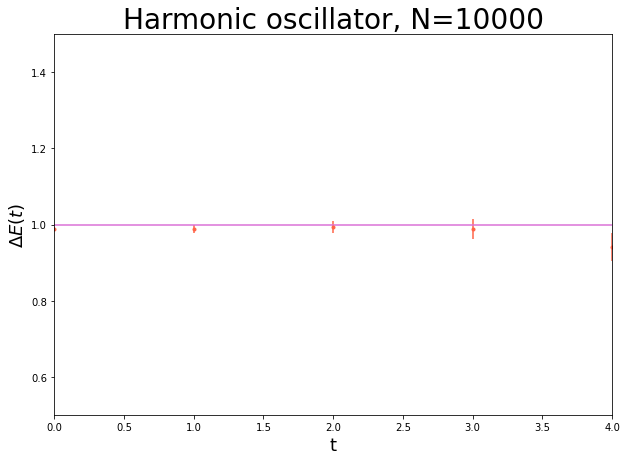

In [57]:
dE=np.zeros((N-1,N_stat),np.float64)
DE=np.zeros((N-1,N_stat),np.float64)
mean_dE=np.zeros(N-1,np.float64)
mean_DE=np.zeros(N-1,np.float64)
mean_dE_square=np.zeros(N-1,np.float64)
error_dE=np.zeros(N-1,np.float64)
error_DE=np.zeros(N-1,np.float64)
#t=np.zeros(N-1,np.float64)
#exact=np.zeros(N-1,np.float64)
#DE=np.zeros((N),np.float64)
MC_avg=0
accept_rate=0

MC_avg,accept_rate=MCaverage(x,G,N_cor,N_cf)
DE=DeltaE(MC_avg)
mean_DE,error_DE=stat_analysis(DE)
print("acceptance rate: "+str(accept_rate))

xaxis=range(N-1)
yaxis=DE

plt.figure(figsize=(10,7)) # 10 is width, 7 is height
plt.title('Harmonic oscillator, N='+str(N_cf),fontsize=28)
plt.errorbar(xaxis,mean_DE,yerr=error_DE,fmt='.',color='tomato',label='numeric')
plt.xlabel(r"t",fontsize=18)
plt.ylabel(r"$\Delta E(t)$",fontsize=18)
plt.xlim(0, 4)
plt.ylim(0.5,1.5)
plt.axhline(y=1, color='orchid', linestyle='-')
#plt.plot(xaxis,yaxis,'o', markersize= 4)

plt.show()